In [1]:
#Importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, random, shutil
import tensorflow as tf
import seaborn
from tensorflow import keras
from tensorflow.keras import preprocessing, layers
from tensorflow.keras.callbacks import EarlyStopping
from keras_preprocessing import image
import PIL
import cv2
from keras.constraints import maxnorm
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator


In [2]:
dataset_url = "https://drive.google.com/file/d/1x3Y4e5j6vI_-uu91Vk-xR-1WlknZquUK/view?usp=sharing"
data_dir = tf.keras.utils.get_file('Dataset 30 New', origin=dataset_url,  cache_dir='.', untar=True)

In [3]:
data_dir

'./datasets/Dataset 30 New'

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/Dataset 30 New')

In [5]:
image_count =  len(list(data_dir.glob('*/*.png'))) + len(list(data_dir.glob('*/*.jpg')))  + len(list(data_dir.glob('*/*.jpeg'))) 
print(image_count)

150


In [6]:
Galaxy_images_dict= {
    'disk': list(data_dir.glob('Disk Galaxy/*')),
    'elliptical': list(data_dir.glob('Elliptical Galaxy/*')),
    'irregular': list(data_dir.glob('Irregular Galaxy/*')),
    'lenticular': list(data_dir.glob('Lenticular Galaxy/*')),
    'spiral':list(data_dir.glob('Spiral Galaxy/*')),
}
Galaxy_labels_dict = {
    'disk':0,
    'elliptical': 1,
    'irregular': 2,
    'lenticular': 3,
    'spiral': 4,
}

In [7]:
img =  cv2.imread(str(Galaxy_images_dict['disk'][4]))

In [8]:
img.shape

(300, 300, 3)

In [9]:
X, y = [],[]

for Galaxy_name, images in Galaxy_images_dict.items():
    for image in images:
        img= cv2.imread(str(image))
        resized_img =  cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(Galaxy_labels_dict[Galaxy_name])

In [10]:
X =  np.array(X)
y = np.array(y)

In [11]:
X.shape

(150, 180, 180, 3)

In [12]:
y.shape

(150,)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=0)

In [14]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [25]:
num_classes = 5

model = Sequential([
    layers.Conv2D(32,(3,3), padding='same', activation='relu', input_shape=(180,180,3)),
    layers.Conv2D(32,(3,3), padding='same', activation='relu', input_shape=(180,180,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3), padding='same', activation='relu'),
    layers.Conv2D(64,(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128,(3,3), padding='same', activation='relu'),
    layers.Conv2D(128,(3,3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),  
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(2048, activation='relu'),
    layers.Dense(2048, activation='relu'),
    layers.Dense(num_classes)    
])


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=10, restore_best_weights=False)
model.fit(X_train_scaled, y_train, epochs=30)

Epoch 1/30


In [17]:
model.evaluate(X_test_scaled,y_test)
model.summary()

2/2 [==============================] - 2s 436ms/step - loss: 2.6821 - accuracy: 0.6800
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
___________________________________

In [18]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np

In [19]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_predict =  model.predict(X_test_scaled)
y_predict_classes = [np.argmax(element) for element in y_predict]
print("Classification Report: \n", classification_report(y_test, y_predict_classes))
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predict_classes)
cm

In [20]:
print("Classification Report: \n", classification_report(y_test, y_predict_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.60      0.67        10
           1       0.55      0.67      0.60         9
           2       0.67      0.67      0.67        12
           3       0.60      0.55      0.57        11
           4       0.89      1.00      0.94         8

    accuracy                           0.68        50
   macro avg       0.69      0.70      0.69        50
weighted avg       0.68      0.68      0.68        50



In [21]:
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predict_classes)
cm

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[6, 0, 4, 0, 0],
       [0, 6, 0, 3, 0],
       [2, 0, 8, 1, 1],
       [0, 5, 0, 6, 0],
       [0, 0, 0, 0, 8]], dtype=int32)>

Text(69.0, 0.5, 'Truth')

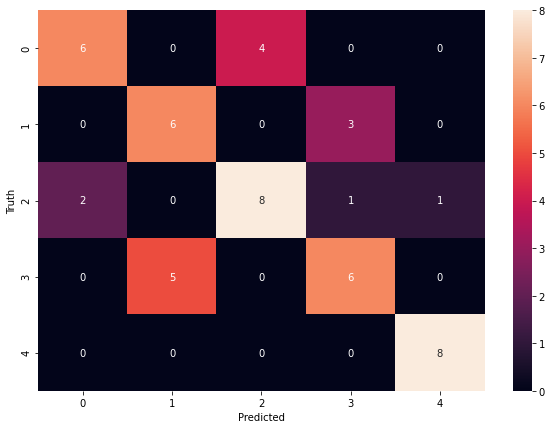

In [22]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')